In [1]:
import pandas as pd
from matplotlib import pyplot
import re
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split

In [2]:
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))
def view_img(pdata):
    pyplot.imshow(pdata, pyplot.cm.gray)
    pyplot.show()

In [3]:
with open('D:/dmarq/Projects/ML/MIAS_Mammography/Info.txt') as file:
    data = file.read()
    arr = data.split("\n")
    for i, each in enumerate(arr):
        arr[i] = each.split()
keys = {key:[] for key in arr[0]}
mam_df = pd.DataFrame(data=arr[1:],columns=keys)

mam_df = mam_df.drop(mam_df[mam_df["CLASS"] == 'ARCH'].iloc[15:].index)
mam_df = mam_df.drop(mam_df[mam_df["CLASS"] == 'NORM'].iloc[15:].index)
mam_df = mam_df.drop(mam_df[mam_df["CLASS"] == 'CIRC'].iloc[15:].index)
mam_df = mam_df.drop(mam_df[mam_df["CLASS"] == 'SPIC'].iloc[15:].index)
mam_df = mam_df.drop(mam_df[mam_df["CLASS"] == 'MISC'].iloc[15:].index)
mam_df = mam_df.drop(mam_df[mam_df["CLASS"] == 'ASYM'].iloc[15:].index)
mam_df = mam_df.drop(mam_df[mam_df["CLASS"] == 'CALC'].iloc[15:].index)

mam_df["CLASS"].describe()
input_shape = (mam_df.shape[0],1024,1024,1)

In [4]:
# np array of model input imgs
input_imgs = []
for file_name in mam_df['REFNUM']:
    pdata = read_pgm('D:/dmarq/Projects/ML/MIAS_Mammography/data/{}.pgm'.format(file_name), byteorder='<')
#     pdata = np.asarray(pdata)[200:900,200:700] # resize
    input_imgs.append(np.asarray(pdata/255.))
input_imgs = np.asarray(input_imgs)
input_imgs = input_imgs.reshape(input_shape)

In [5]:
CLASS_KEY = ["NORM","CALC","CIRC","SPIC","MISC","ARCH","ASYM"]
CLASS_COLOR = np.array([0,36,36*2,36*3,36*4,36*5,36*6])/216.
CLASS_df = pd.DataFrame(CLASS_KEY,columns=["CLASS"])
# CLASS_df.head(10)

In [6]:
def translate_label(label):
    key = CLASS_KEY[np.argmax(label)]
    x = label[1]*1024
    y = label[2]*1024
    radius = label[3]*150
    return key # ,x,y,radius]

In [7]:
output_imgs = np.zeros((len(input_imgs),1024,1024,1)) # imgs are 1024x1024
for mam, loc in enumerate(mam_df[["CLASS","X","Y","RADIUS"]].values):
    if loc[0] != "NORM":
        if loc[1] == None:
            x = 1024//2
            y = 1024//2
            radius = 150
        else:
            x = int(loc[1])
            y = int(loc[2])
            radius = int(loc[3])
        color = CLASS_COLOR[CLASS_KEY.index(loc[0])]
        for i in range(x-radius//2,x+radius//2):
            for j in range(y-radius//2,y+radius//2):
                output_imgs[mam][i][j] = color
    else:
        output_imgs[mam] = None

In [8]:
output_list = np.zeros((input_shape[0],7))
for mam, loc in enumerate(mam_df[["CLASS","X","Y","RADIUS"]].values):
#     if loc[0] != "NORM":
#         if loc[1] == None:
#             x = 1024//2
#             y = 1024//2
#             radius = 150
#         else:
#             x = int(loc[1])
#             y = int(loc[2])
#             radius = int(loc[3])
#         color = CLASS_COLOR[CLASS_KEY.index(loc[0])]
    output_list[mam] = np.zeros(7)
    output_list[mam][CLASS_KEY.index(loc[0])] = 1

['CIRC' '522' '280' '69']
[0. 0. 1. 0. 0. 0. 0.]


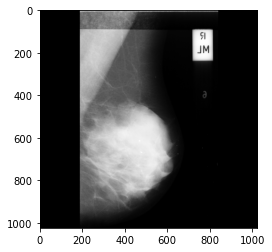

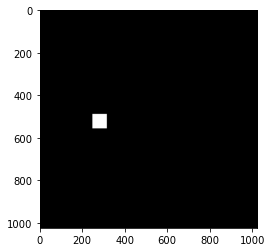

In [9]:
index = 1
print(mam_df[["CLASS","X","Y","RADIUS"]].values[index])
print(output_list[index])
view_img(input_imgs[index])
view_img(output_imgs[index])

In [10]:
# PCA region
# activeregion = np.zeros((700,500,1))
# for img in input_imgs:
#     activeregion += img
# activeregion /= len(input_imgs)
# view_img(activeregion)

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(input_imgs, output_list,train_size=.6, shuffle=True)

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (4,4), input_shape=input_shape[1:]))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(32, (4,4)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(16, (4,4)))
model.add(layers.Activation('relu'))

model.add(layers.GlobalMaxPooling2D())

model.add(layers.Dense(32))
model.add(layers.Activation('relu'))
model.add(layers.ActivityRegularization(l2=1e-4)) # try just l2 loss
model.add(layers.Dense(16))
model.add(layers.Activation('relu'))
model.add(layers.Dense(16))
model.add(layers.Activation('relu'))
model.add(layers.Dense(7))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(lr=3e-2,momentum=.97),
                  metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1021, 1021, 32)    544       
_________________________________________________________________
activation_7 (Activation)    (None, 1021, 1021, 32)    0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 340, 340, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 337, 337, 32)      16416     
_________________________________________________________________
activation_8 (Activation)    (None, 337, 337, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 16)     

In [19]:
with tf.device('/GPU:1'):
    model.fit(X_train,Y_train,validation_data=(X_test, Y_test),verbose=1,epochs=3,batch_size=5,shuffle=True)

Epoch 1/3
17/17 [==============================] - 33s 2s/step - loss: 1.9362 - accuracy: 0.2235 - val_loss: 1.9927 - val_accuracy: 0.0862
Epoch 2/3
17/17 [==============================] - 34s 2s/step - loss: 1.9468 - accuracy: 0.2353 - val_loss: 2.1154 - val_accuracy: 0.0862
Epoch 3/3
17/17 [==============================] - 33s 2s/step - loss: 1.9103 - accuracy: 0.2353 - val_loss: 2.0347 - val_accuracy: 0.0862


In [23]:
y = model.predict(X_test)

In [24]:
y_pred = []
for i , j in enumerate(y):
#     print("actual",mam_df[["CLASS"]].values[i] == translate_label(j))
#     print(j)
    y_pred.append(translate_label(j))
#     print("")
#     view_img(input_imgs[i])
#     view_img(output_imgs[i])
# print(y_pred)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

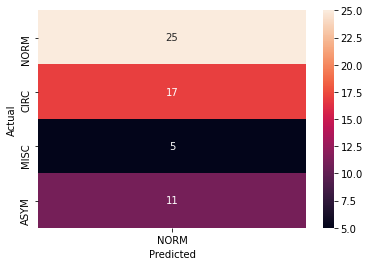

In [25]:
data = {'y_Actual':    Y_test, # mam_df["CLASS"].values[0:len(y_pred)],
        'y_Predicted': y_pred
        }
df_actual = pd.Categorical(mam_df["CLASS"].values[0:len(y_pred)], categories=CLASS_KEY)
df_pred = pd.Categorical(y_pred, categories=CLASS_KEY)

confusion_matrix = pd.crosstab(df_actual,df_pred, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)